# **Milestone 2 - Fingerprint Processing**

This section contains tasks that will help you get familiar with the basics of fingerprint processing.

You may add more code and markdown cells as needed

## TASK 1
* Load the Fingerprint Image `datasets\task3\1.tiff`
* Display it using `plt.imshow()`
* Load the Fingerprint Image `datasets\task3\2.tiff`
* Display it using `plt.imshow()`

#### Load the Fingerprint Image `datasets\task3\1.tiff`

#### Display the Fingerprint image

#### Load the Fingerprint Image `datasets\task3\2.tiff`

#### Display the Second Fingerprint image

## TASK 2
* Extract the minutia points from the fingerprint images
* Display the minutia vectors

Hint: Each minutiae vector will have the following format: 
> `[x, y, theta, type]` where `type` is `0` for ridge ending and `1` for ridge bifurcation

#### Extract the minutia vectors from the fingerprint images of `TASK 1` as a list of vectors

In [7]:
## Hint: use any library you can find from anywhere (but mention the source here in the notebook as a comment)
import skimage



#### Display the minutia vectors

## TASK 3
* Display the minutia vectors on the fingerprint images

#### Display the minutia vectors from `TASK 2` on the fingerprint images of `TASK 1`

In [32]:
import cv2
import numpy as np
import skimage.morphology
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square
import math
import matplotlib.pyplot as plt
from PIL import Image
class MinutiaeFeature(object):
    def __init__(self, locX, locY, Orientation, Type):
        self.locX = locX
        self.locY = locY
        self.Orientation = Orientation
        self.Type = Type

class FingerprintFeatureExtractor(object):
    def __init__(self):
        self._mask = []
        self._skel = []
        self.minutiaeTerm = []
        self.minutiaeBif = []
        self._spuriousMinutiaeThresh = 10

    


    def setSpuriousMinutiaeThresh(self, spuriousMinutiaeThresh):
        self._spuriousMinutiaeThresh = spuriousMinutiaeThresh

    def __skeletonize(self, img):
        img = np.uint8(img > 128)
        self._skel = skimage.morphology.skeletonize(img)
        self._skel = np.uint8(self._skel) * 255
        self._mask = img * 255

    def __computeAngle(self, block, minutiaeType):
        angle = []
        (blkRows, blkCols) = np.shape(block)
        CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
        if (minutiaeType.lower() == 'termination'):
            sumVal = 0
            for i in range(blkRows):
                for j in range(blkCols):
                    if ((i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0):
                        angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
                        sumVal += 1
                        if (sumVal > 1):
                            angle.append(float('nan'))
            return (angle)

        elif (minutiaeType.lower() == 'bifurcation'):
            (blkRows, blkCols) = np.shape(block)
            CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
            angle = []
            sumVal = 0
            for i in range(blkRows):
                for j in range(blkCols):
                    if ((i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0):
                        angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
                        sumVal += 1
            if (sumVal != 3):
                angle.append(float('nan'))
            return (angle)

    def __getTerminationBifurcation(self):
        self._skel = self._skel == 255
        (rows, cols) = self._skel.shape
        self.minutiaeTerm = np.zeros(self._skel.shape)
        self.minutiaeBif = np.zeros(self._skel.shape)

        for i in range(1, rows - 1):
            for j in range(1, cols - 1):
                if (self._skel[i][j] == 1):
                    block = self._skel[i - 1:i + 2, j - 1:j + 2]
                    block_val = np.sum(block)
                    if (block_val == 2):
                        self.minutiaeTerm[i, j] = 1
                    elif (block_val == 4):
                        self.minutiaeBif[i, j] = 1

        self._mask = convex_hull_image(self._mask > 0)
        self._mask = erosion(self._mask, square(5))  # Structuing element for mask erosion = square(5)
        self.minutiaeTerm = np.uint8(self._mask) * self.minutiaeTerm

    def __removeSpuriousMinutiae(self, minutiaeList, img):
        img = img * 0
        SpuriousMin = []
        numPoints = len(minutiaeList)
        D = np.zeros((numPoints, numPoints))
        for i in range(1,numPoints):
            for j in range(0, i):
                (X1,Y1) = minutiaeList[i]['centroid']
                (X2,Y2) = minutiaeList[j]['centroid']

                dist = np.sqrt((X2-X1)**2 + (Y2-Y1)**2)
                D[i][j] = dist
                if(dist < self._spuriousMinutiaeThresh):
                    SpuriousMin.append(i)
                    SpuriousMin.append(j)

        SpuriousMin = np.unique(SpuriousMin)
        for i in range(0,numPoints):
            if(not i in SpuriousMin):
                (X,Y) = np.int16(minutiaeList[i]['centroid'])
                img[X,Y] = 1

        img = np.uint8(img)
        return(img)

    def __cleanMinutiae(self, img):
        self.minutiaeTerm = skimage.measure.label(self.minutiaeTerm, connectivity=2)
        RP = skimage.measure.regionprops(self.minutiaeTerm)
        self.minutiaeTerm = self.__removeSpuriousMinutiae(RP, np.uint8(img))

    def __performFeatureExtraction(self):
        FeaturesTerm = []
        self.minutiaeTerm = skimage.measure.label(self.minutiaeTerm, connectivity=2)
        RP = skimage.measure.regionprops(np.uint8(self.minutiaeTerm))

        WindowSize = 2  # --> For Termination, the block size must can be 3x3, or 5x5. Hence the window selected is 1 or 2
        FeaturesTerm = []
        for num, i in enumerate(RP):
            (row, col) = np.int16(np.round(i['Centroid']))
            block = self._skel[row - WindowSize:row + WindowSize + 1, col - WindowSize:col + WindowSize + 1]
            angle = self.__computeAngle(block, 'Termination')
            if(len(angle) == 1):
                FeaturesTerm.append(MinutiaeFeature(row, col, angle, 'Termination'))
                
        FeaturesBif = []
        self.minutiaeBif = skimage.measure.label(self.minutiaeBif, connectivity=2)
        RP = skimage.measure.regionprops(np.uint8(self.minutiaeBif))
        WindowSize = 1  # --> For Bifurcation, the block size must be 3x3. Hence the window selected is 1
        for i in RP:
            (row, col) = np.int16(np.round(i['Centroid']))
            block = self._skel[row - WindowSize:row + WindowSize + 1, col - WindowSize:col + WindowSize + 1]
            angle = self.__computeAngle(block, 'Bifurcation')
            if(len(angle) == 3):
                FeaturesBif.append(MinutiaeFeature(row, col, angle, 'Bifurcation'))
                
      
        return (FeaturesTerm, FeaturesBif)

    def extractMinutiaeFeatures(self, img):
        self.__skeletonize(img)

        self.__getTerminationBifurcation()

        self.__cleanMinutiae(img)

        FeaturesTerm, FeaturesBif = self.__performFeatureExtraction()
      
        return(FeaturesTerm, FeaturesBif)

    def showResults(self, FeaturesTerm, FeaturesBif):
        
        img = Image.open('./datasets/task3/2.tiff')
        
        img_arr = np.array(img)
        (rows, cols) = img_arr.shape
        DispImg = np.zeros((rows, cols, 3), np.uint8)
        DispImg2 = np.zeros((rows, cols, 3), np.uint8)

        DispImg[:, :, 0] = 255 * self._skel
        DispImg[:, :, 1] = 255 * self._skel
        DispImg[:, :, 2] = 255 * self._skel
        
        DispImg2[:, :, 0] = img_arr
        DispImg2[:, :, 1] = img_arr
        DispImg2[:, :, 2] = img_arr
        cv2.imwrite('skl.png', DispImg)

        cv2.imwrite('org.png', DispImg2)
        for idx, curr_minutiae in enumerate(FeaturesTerm):
            row, col = curr_minutiae.locX, curr_minutiae.locY
            (rr, cc) = skimage.draw.circle_perimeter(row, col, 3)
            skimage.draw.set_color(DispImg, (rr, cc), (255, 0, 0))
            skimage.draw.set_color(DispImg2, (rr, cc), (255, 0, 0))

        for idx, curr_minutiae in enumerate(FeaturesBif):
            row, col = curr_minutiae.locX, curr_minutiae.locY
            (rr, cc) = skimage.draw.rectangle_perimeter((row - 2, col - 2),  end=(row + 2, col + 2))
            skimage.draw.set_color(DispImg, (rr, cc), (0, 0, 255))
            skimage.draw.set_color(DispImg2, (rr, cc), (0, 0, 255))


       
        cv2.imwrite('result3.png', DispImg)
        cv2.imwrite('result4.png', DispImg2)

    def saveResult(self, FeaturesTerm, FeaturesBif):
        img = Image.open('./datasets/task3/1.tiff')
        
        img_arr = np.array(img)
        (rows, cols) = img_arr.shape
        DispImg = np.zeros((rows, cols, 3), np.uint8)
        DispImg2 = np.zeros((rows, cols, 3), np.uint8)

        DispImg[:, :, 0] = 255 * self._skel
        DispImg[:, :, 1] = 255 * self._skel
        DispImg[:, :, 2] = 255 * self._skel
        
        DispImg2[:, :, 0] = img_arr
        DispImg2[:, :, 1] = img_arr
        DispImg2[:, :, 2] = img_arr
        cv2.imwrite('skl.png', DispImg)

        cv2.imwrite('org.png', DispImg2)
        for idx, curr_minutiae in enumerate(FeaturesTerm):
            row, col = curr_minutiae.locX, curr_minutiae.locY
            (rr, cc) = skimage.draw.circle_perimeter(row, col, 3)
            skimage.draw.set_color(DispImg, (rr, cc), (255, 0, 0))
            skimage.draw.set_color(DispImg2, (rr, cc), (255, 0, 0))

        for idx, curr_minutiae in enumerate(FeaturesBif):
            row, col = curr_minutiae.locX, curr_minutiae.locY
            (rr, cc) = skimage.draw.rectangle_perimeter((row - 2, col - 2),  end=(row + 2, col + 2))
            skimage.draw.set_color(DispImg, (rr, cc), (0, 0, 255))
            skimage.draw.set_color(DispImg2, (rr, cc), (0, 0, 255))


       
        cv2.imwrite('result.png', DispImg)
        cv2.imwrite('result2.png', DispImg2)


    

   
            
def extract_minutiae_features(img, spuriousMinutiaeThresh=10, invertImage=False, showResult=False, saveResult=False):
    feature_extractor = FingerprintFeatureExtractor()
    feature_extractor.setSpuriousMinutiaeThresh(spuriousMinutiaeThresh)
    if (invertImage):
        img = 255 - img

    FeaturesTerm, FeaturesBif = feature_extractor.extractMinutiaeFeatures(img)

    if (saveResult):
        feature_extractor.saveResult(FeaturesTerm, FeaturesBif)

    if(showResult):
        feature_extractor.showResults(FeaturesTerm, FeaturesBif)

    return(FeaturesTerm, FeaturesBif)





In [38]:

img = cv2.imread('./datasets/task3/1.tiff', 0)				# read the input image --> You can enhance the fingerprint image using the "fingerprint_enhancer" library
FeaturesTerminations, FeaturesBifurcations = extract_minutiae_features(img, spuriousMinutiaeThresh=10, invertImage=True, showResult=False, saveResult=True)



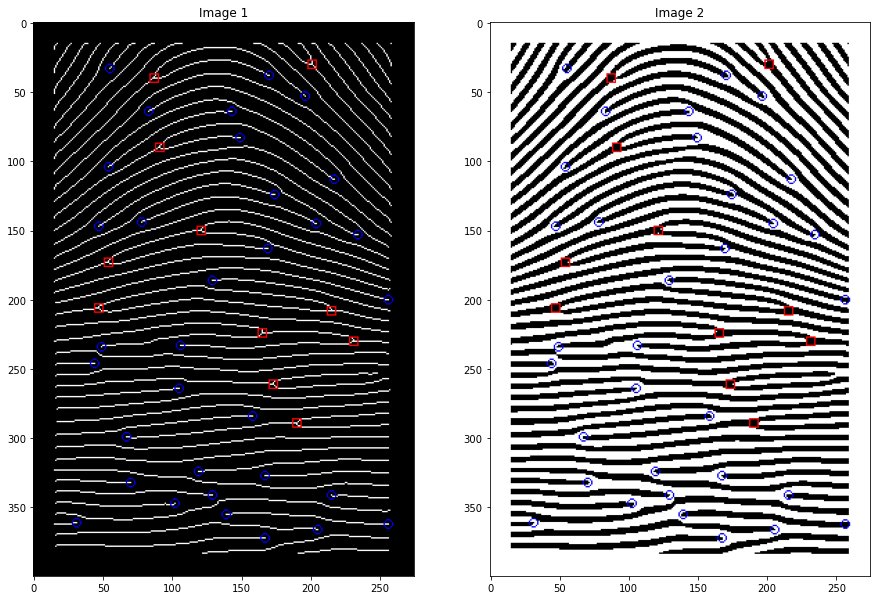

In [39]:


## Hint: use matplotlib and stacked images to show the results
## Use red circle for ridge ending and blue square for ridge bifurcation


import matplotlib.pyplot as plt
import cv2

# img = cv2.imread("result.png")

# img2 = cv2.imread("result2.png")
# fig, ax = plt.subplots(figsize=(10,10))
# ax.imshow(img, cmap='gray')
# plt.show()



# Load two example images
img1 = plt.imread('result.png')
img2 = plt.imread('result2.png')

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 15))

# Plot the first image in the left subplot
axs[0].imshow(img1)
axs[0].set_title('Image 1')


axs[1].imshow(img2)
axs[1].set_title('Image 2')

# Show the figure
plt.show()

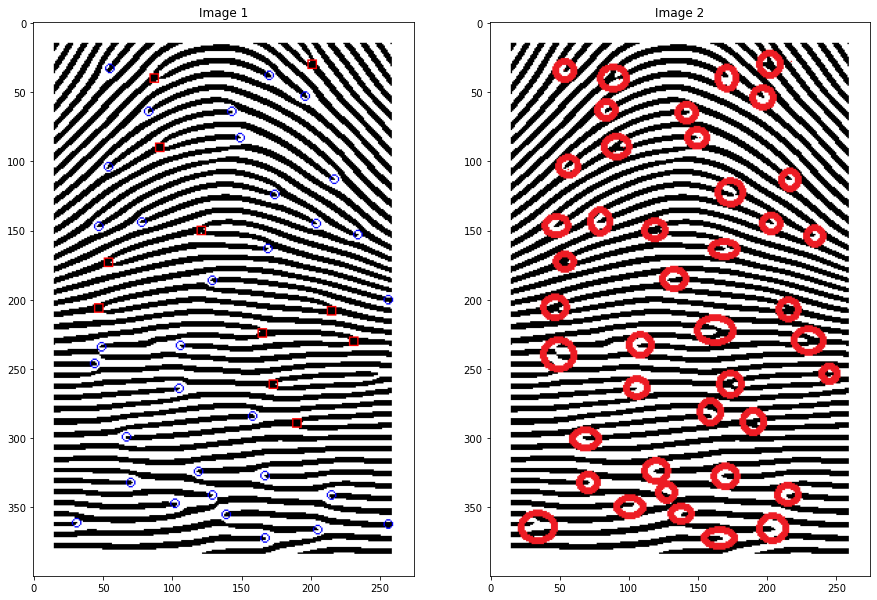

In [40]:

import matplotlib.pyplot as plt
import cv2

# img = cv2.imread("result.png")

# img2 = cv2.imread("result2.png")
# fig, ax = plt.subplots(figsize=(10,10))
# ax.imshow(img, cmap='gray')
# plt.show()



# Load two example images
img1 = plt.imread('result2.png')
img2 = plt.imread('./datasets/task3/ground_truths/1_gt.tiff')

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 15))

# Plot the first image in the left subplot
axs[0].imshow(img1)
axs[0].set_title('Image 1')


axs[1].imshow(img2)
axs[1].set_title('Image 2')

# Show the figure
plt.show()

In [41]:
i=0
j=0
for obj in FeaturesTerminations:
    i=i+1
    #print(obj.locX, obj.locY, obj.Orientation, obj.Type)
    

for obj in FeaturesBifurcations:
    j=j+1
    #print(obj.locX, obj.locY, obj.Orientation, obj.Type)
print(i)
print(j)
print(i+j)    

33
11
44


In [42]:

img = cv2.imread('./datasets/task3/2.tiff', 0)				# read the input image --> You can enhance the fingerprint image using the "fingerprint_enhancer" library
FeaturesTerminations, FeaturesBifurcations = extract_minutiae_features(img, spuriousMinutiaeThresh=10, invertImage=True, showResult=True, saveResult=False)



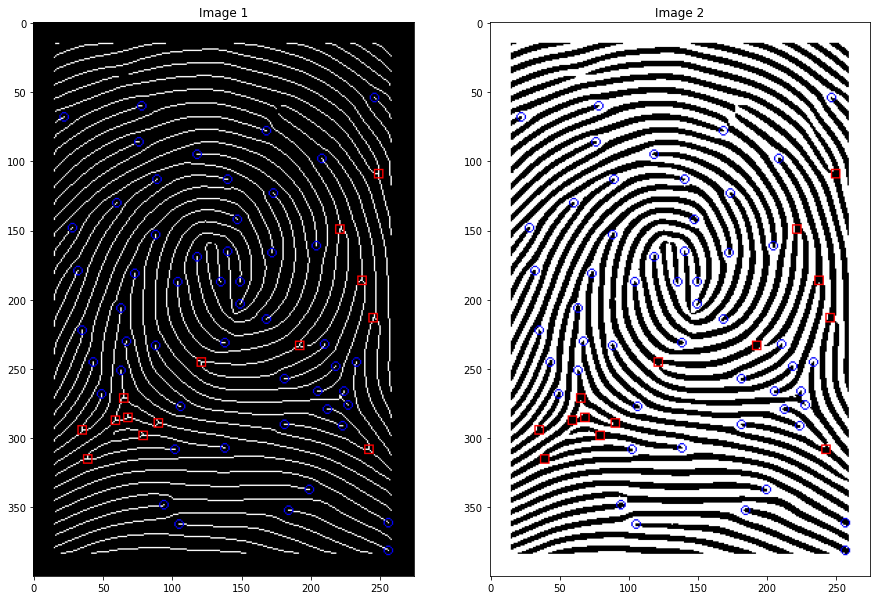

In [43]:


## Hint: use matplotlib and stacked images to show the results
## Use red circle for ridge ending and blue square for ridge bifurcation


import matplotlib.pyplot as plt
import cv2

# img = cv2.imread("result.png")

# img2 = cv2.imread("result2.png")
# fig, ax = plt.subplots(figsize=(10,10))
# ax.imshow(img, cmap='gray')
# plt.show()



# Load two example images
img1 = plt.imread('result3.png')
img2 = plt.imread('result4.png')

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 15))

# Plot the first image in the left subplot
axs[0].imshow(img1)
axs[0].set_title('Image 1')


axs[1].imshow(img2)
axs[1].set_title('Image 2')

# Show the figure
plt.show()

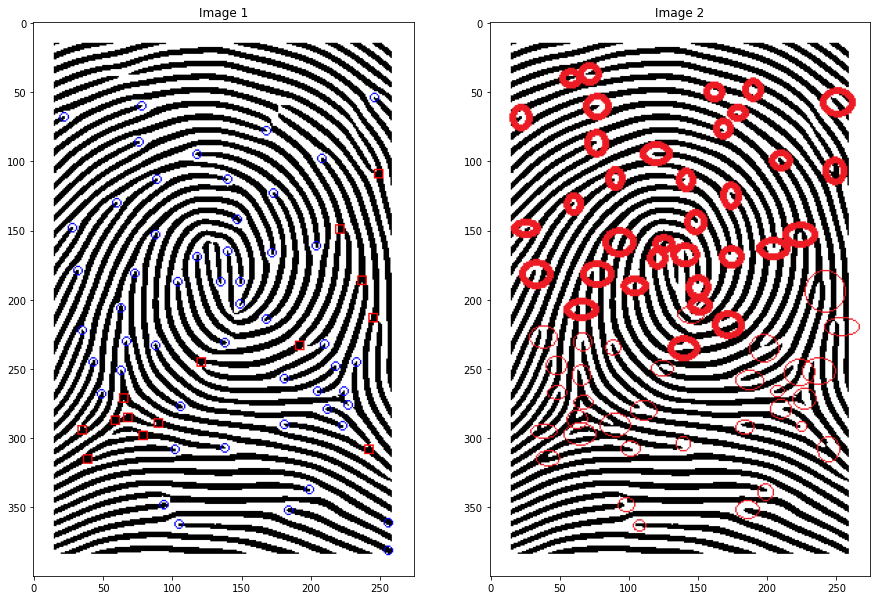

In [46]:
import matplotlib.pyplot as plt
import cv2

# img = cv2.imread("result.png")

# img2 = cv2.imread("result2.png")
# fig, ax = plt.subplots(figsize=(10,10))
# ax.imshow(img, cmap='gray')
# plt.show()



# Load two example images
img1 = plt.imread('result4.png')
img2 = plt.imread('./datasets/task3/ground_truths/2_gt.tiff')

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 15))

# Plot the first image in the left subplot
axs[0].imshow(img1)
axs[0].set_title('Image 1')


axs[1].imshow(img2)
axs[1].set_title('Image 2')

# Show the figure
plt.show()

In [47]:
i=0
j=0
for obj in FeaturesTerminations:
    i=i+1
    #print(obj.locX, obj.locY, obj.Orientation, obj.Type)
    

for obj in FeaturesBifurcations:
    j=j+1
    #print(obj.locX, obj.locY, obj.Orientation, obj.Type)
print(i)
print(j)
print(i+j) 

52
14
66


In [12]:
for obj in FeaturesTerminations:
    print(obj.locX, obj.locY, obj.Orientation, int(obj.Type == 'Bifurcation'))
    

for obj in FeaturesBifurcations:
    print(obj.locX, obj.locY, obj.Orientation, int(obj.Type == 'Bifurcation'))
    

33 55 [45.0] 0
38 170 [153.434948822922] 0
53 196 [135.0] 0
64 83 [26.56505117707799] 0
64 143 [-180.0] 0
83 149 [-180.0] 0
104 54 [26.56505117707799] 0
113 217 [153.434948822922] 0
124 174 [-180.0] 0
144 78 [26.56505117707799] 0
145 204 [153.434948822922] 0
147 47 [26.56505117707799] 0
153 234 [-180.0] 0
163 169 [-180.0] 0
186 129 [-0.0] 0
200 256 [-180.0] 0
233 106 [-0.0] 0
234 49 [26.56505117707799] 0
246 44 [-180.0] 0
264 105 [-180.0] 0
284 158 [-180.0] 0
299 67 [-0.0] 0
324 119 [-0.0] 0
327 167 [-0.0] 0
332 70 [-180.0] 0
341 129 [-180.0] 0
341 215 [-26.56505117707799] 0
347 102 [-153.434948822922] 0
355 139 [-0.0] 0
361 31 [-180.0] 0
362 256 [-180.0] 0
366 205 [153.434948822922] 0
372 167 [-180.0] 0
30 201 [90.0, -180.0, -45.0] 1
40 87 [90.0, -180.0, -0.0] 1
90 91 [90.0, -180.0, -45.0] 1
150 121 [90.0, -180.0, -45.0] 1
173 54 [90.0, -180.0, -45.0] 1
206 47 [90.0, -180.0, -45.0] 1
208 215 [90.0, -180.0, -0.0] 1
224 165 [90.0, -0.0, -135.0] 1
230 231 [90.0, -180.0, -0.0] 1
261 173 [

(400, 275)


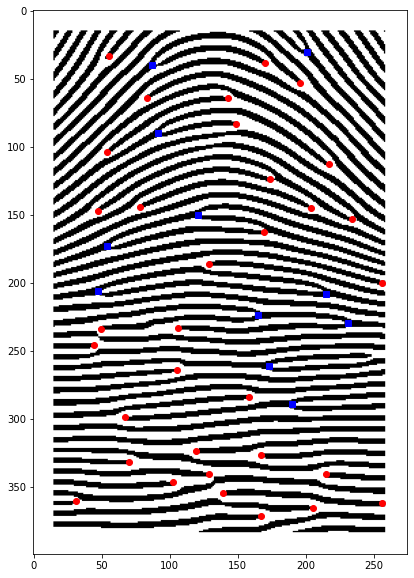

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the fingerprint image
img = Image.open('./datasets/task3/1.tiff')
img_arr = np.array(img)
print(img_arr.shape)
# img_arr = 255 - img_arr

# Display the fingerprint image
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img_arr, cmap='gray')
# Loop through the minutiae and plot them on the image
for i, term in enumerate(FeaturesTerminations):
    x, y, direction, minutia_type = term.locX, term.locY, term.Orientation, term.Type
    marker = 'o'
    color = 'r'
    ax.plot(y, x, marker=marker, color=color)
# iterate over the bifurcations and draw them on the image
for i, bif in enumerate(FeaturesBifurcations):
    x, y, direction, minutia_type = bif.locX, bif.locY,  bif.Orientation, bif.Type
    marker = 's'
    color = 'b' 
    # Plot the marker on the image
    ax.plot(y, x, marker=marker, color=color)
    
# Show the image with minutiae
plt.show()
